In experiment 4 we will be unfreezing top layers of EfficientNEtB0 and start training from where the experiment 3 was finished i.e. from epoch 5.

1. Importing helping functions and the data

In [6]:
from help_functions import download_and_unzip, dir_explore, create_callbacks, plot_loss_curves, view_random_image

In [2]:
url =  'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
zip_file_name = '10_food_classes_10_percent.zip'
data_folder_path = zip_file_name[:-4]

download_and_unzip(url, zip_file_name)

Beginning file download...


In [3]:
dir_explore(zip_file_name[:-4])

There are 2 directories and 0 files in 10_food_classes_10_percent folder.
There are 10 directories and 0 files in 10_food_classes_10_percent\test folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\chicken_curry folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\chicken_wings folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\fried_rice folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\grilled_salmon folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\hamburger folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\ice_cream folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\pizza folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\ramen folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\steak folder.
There are 0 directories a

2. Defining the training and testing data flow process.

In [4]:
import tensorflow as tf

batch_size=32
image_size=(222,222)

train_data_dir = data_folder_path + '/train'
test_data_dir = data_folder_path + '/test'

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, 
                                                                batch_size=batch_size, 
                                                                image_size=image_size,
                                                                label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_data_dir, 
                                                                batch_size=batch_size, 
                                                                image_size=image_size,
                                                                 label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


3. Defining data augmentation layers

In [5]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name = 'data_augmentation')

4. Viewing a random image with/without data augmentation.

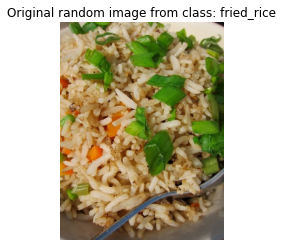

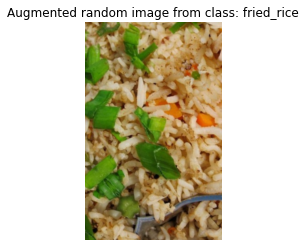

In [8]:
import matplotlib.pyplot as plt

img, target_class = view_random_image(train_data_dir)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [21]:
from tensorflow import keras

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

input = tf.keras.layers.Input(shape = image_size + (3,) , name="input_layer")

x = data_augmentation(input)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

output = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(x)

model_3 = keras.Model(input, output)

5. Defining the model sequence.

In [22]:
import tensorflow as tf
model_3 = tf.keras.models.load_model('Models\Exp_03_Models\model_2_ep_05_val_accuracy_0.8059.h5')

In [23]:
model_3.evaluate(test_data)

79/79 [==============================] - 53s 658ms/step - loss: 0.9056 - accuracy: 0.7184


[0.9056060314178467, 0.7184000015258789]

In [18]:
base_model.trainable = True

for layer in model_3.layers:
  print(layer.trainable)

model_3.layers


True
True
True
True
True


In [19]:
print(len(model_3.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)
print(len(base_model.trainable_variables))

0
211


In [20]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 block

6. Compiling and fitting the model

In [54]:
from tensorflow.keras.optimizers import Adam
model_1.compile(loss = 'categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_1_history = model_1.fit(train_data, 
            steps_per_epoch=len(train_data), 
            epochs=5,   
            validation_data=test_data, 
            validation_steps=int(0.25*len(test_data)),
            callbacks = create_callbacks(tensorboard_dir_name='TensorBoard',
                                            experiment_name= 'EfficientNet_FineTuning_Exp_02',
                                            checkpoint_path = 'Models/Exp_02_Models/model_1_ep_{epoch:02d}_val_accuracy_{val_accuracy:.04f}.h5')
                                            )

Saving TensorBoard log files to: TensorBoard/EfficientNet_FineTuning_Exp_02/20211124-234511
Epoch 1/5


C:\Users\Sahil\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 23s 8s/step - loss: 2.4591 - accuracy: 0.0571 - val_loss: 2.2872 - val_accuracy: 0.1447
Epoch 2/5
3/3 [==============================] - 16s 7s/step - loss: 2.1855 - accuracy: 0.2571 - val_loss: 2.1599 - val_accuracy: 0.2089
Epoch 3/5
3/3 [==============================] - 15s 7s/step - loss: 2.0008 - accuracy: 0.3857 - val_loss: 2.0505 - val_accuracy: 0.3092
Epoch 4/5
3/3 [==============================] - 15s 7s/step - loss: 1.8286 - accuracy: 0.4714 - val_loss: 1.9473 - val_accuracy: 0.3635
Epoch 5/5
3/3 [==============================] - 15s 7s/step - loss: 1.6890 - accuracy: 0.6000 - val_loss: 1.8423 - val_accuracy: 0.4622


7. Model evaluation and plotting the loss curves

In [55]:
model_1.evaluate(test_data)

79/79 [==============================] - 57s 712ms/step - loss: 1.8638 - accuracy: 0.4284


[1.8637548685073853, 0.4284000098705292]

42 % is not a good accuracy - Increasing the training data can help.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


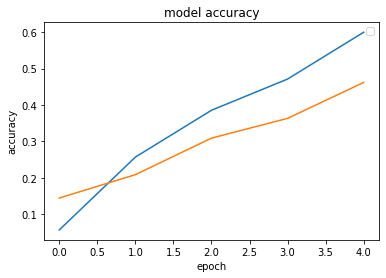

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


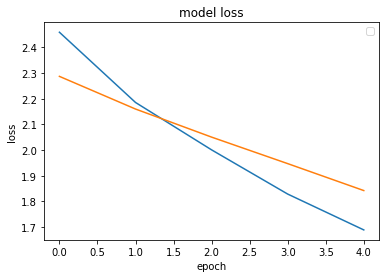

In [57]:
plot_loss_curves(model_1_history)

In [58]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 222, 222, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina